In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json
/kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json
/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json
/kaggle/input/arc-prize-2024/sample_submission.json
/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json
/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json


In [2]:
#inspect json files
import json

#list of JSON file paths
json_files = ['/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json',
    '/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json',
    '/kaggle/input/arc-prize-2024/sample_submission.json',
    '/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json',
     '/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json'
             ]

#read and print json structure
def print_json_structure(file_path):
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
            print(f"Structure of {file_path}:")
            print(json.dumps(data, indent=2)[:100] + "...\n")  #only the fist 50 characters will be displayed
    except FileNotFoundError:
        print(f"File not found: {file_path}")

#read and print structure of each json file
for path in json_files:
    print_json_structure(path)

Structure of /kaggle/input/arc-prize-2024/arc-agi_training_solutions.json:
{
  "007bbfb7": [
    [
      [
        7,
        0,
        7,
        0,
        0,
        0,
  ...

Structure of /kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json:
{
  "00576224": {
    "test": [
      {
        "input": [
          [
            3,
            2
...

Structure of /kaggle/input/arc-prize-2024/sample_submission.json:
{
  "007bbfb7": [
    {
      "attempt_1": [
        [
          0,
          0
        ],
        [...

Structure of /kaggle/input/arc-prize-2024/arc-agi_training_challenges.json:
{
  "007bbfb7": {
    "test": [
      {
        "input": [
          [
            7,
            0,...

Structure of /kaggle/input/arc-prize-2024/arc-agi_test_challenges.json:
{
  "007bbfb7": {
    "test": [
      {
        "input": [
          [
            7,
            0,...



In [3]:
#load and preprocess ARC dataset into input-output pairs
import torch
from torch.utils.data import DataLoader, Dataset

#file paths
train_solutions_path = '/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json'
train_challenges_path = '/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'

#load json data
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

#preprocess data into input-output pairs
def preprocess_data(challenges, solutions):
    data = []
    for task_id, task_data in challenges.items():
        input_grids = []
        output_grids = []
        for test_case in task_data['test']:
            input_grid = np.array(test_case['input'], dtype=np.float32)
            output_grid = np.array(solutions[task_id][0], dtype=np.float32)  #assuming first solution
            input_grids.append(input_grid)
            output_grids.append(output_grid)
        data.append((input_grids, output_grids))
    return data

#load training challenges and solutions
train_challenges = load_json(train_challenges_path)
train_solutions = load_json(train_solutions_path)

#preprocess training data
train_data = preprocess_data(train_challenges, train_solutions)

In [4]:
#identify the maximum height and width of the grids in the ARC dataset

def preprocess_data(challenges, solutions):
    max_height = 0
    max_width = 0
    data = []
    
    for task_id, task_data in challenges.items():
        input_grids = []
        output_grids = []
        
        for test_case in task_data['test']:
            input_grid = np.array(test_case['input'], dtype=np.float32)
            output_grid = np.array(solutions[task_id][0], dtype=np.float32)  #assuming first solution
            
            input_height, input_width = input_grid.shape
            output_height, output_width = output_grid.shape
            
            max_height = max(max_height, input_height, output_height)
            max_width = max(max_width, input_width, output_width)
            
            input_grids.append(input_grid)
            output_grids.append(output_grid)
        
        data.append((input_grids, output_grids))
    
    print(f"Maximum height: {max_height}, Maximum width: {max_width}")
    return data

In [5]:
#load training challenges and solutions
train_challenges = load_json(train_challenges_path)
train_solutions = load_json(train_solutions_path)

In [6]:
#preprocess training data
train_data = preprocess_data(train_challenges, train_solutions)

Maximum height: 30, Maximum width: 30


In [7]:
#print sample input-output pairs
def print_sample_pairs(challenges, solutions, num_samples=5):
    sample_tasks = list(challenges.keys())[:num_samples]
    
    for task_id in sample_tasks:
        task_data = challenges[task_id]
        input_grid = np.array(task_data['test'][0]['input'])  #taking the first test case
        output_grid = np.array(solutions[task_id][0])  #assuming first solution
        
        print(f"Task ID: {task_id}")
        print("Input Grid:")
        print(input_grid)
        print("Output Grid:")
        print(output_grid)
        print()

#print sample input-output pairs
print("Sample Input-Output Pairs:")
print_sample_pairs(train_challenges, train_solutions)

Sample Input-Output Pairs:
Task ID: 007bbfb7
Input Grid:
[[7 0 7]
 [7 0 7]
 [7 7 0]]
Output Grid:
[[7 0 7 0 0 0 7 0 7]
 [7 0 7 0 0 0 7 0 7]
 [7 7 0 0 0 0 7 7 0]
 [7 0 7 0 0 0 7 0 7]
 [7 0 7 0 0 0 7 0 7]
 [7 7 0 0 0 0 7 7 0]
 [7 0 7 7 0 7 0 0 0]
 [7 0 7 7 0 7 0 0 0]
 [7 7 0 7 7 0 0 0 0]]

Task ID: 00d62c1b
Input Grid:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 3 3 3 3 3 0 3 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 3 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 3 3 3 3 3 0 3 3 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 3 3 3 3 3 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 3 0 0 0 3 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 3 3 3 3 3 3 0 0 0 3 0 0]
 [0 0 0 0 0 0 3 3 0 3 0 0 0 3 3 3 3 3 0 0]
 [0 0 3 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 3 0 3 3 3 3 3 3 0 0 0 0 0 

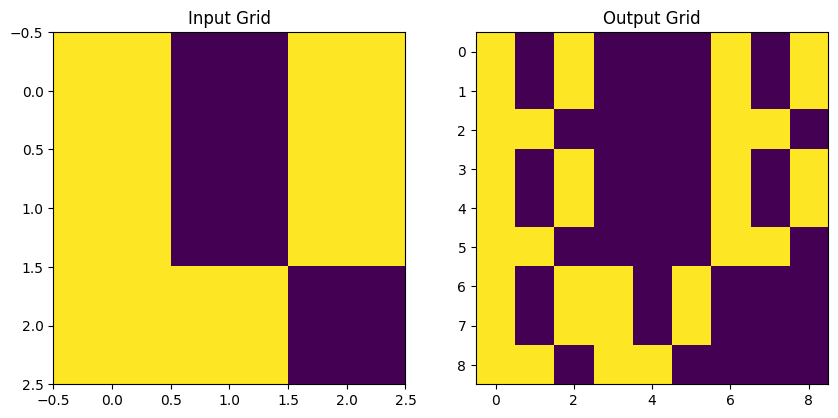

In [8]:
import matplotlib.pyplot as plt

#visualize sample grids
def visualize_grids(input_grid, output_grid):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(input_grid, cmap='viridis')
    axes[0].set_title('Input Grid')
    
    axes[1].imshow(output_grid, cmap='viridis')
    axes[1].set_title('Output Grid')
    
    plt.show()

sample_task_id = list(train_challenges.keys())[0]
sample_input = np.array(train_challenges[sample_task_id]['test'][0]['input'])
sample_output = np.array(train_solutions[sample_task_id][0])

visualize_grids(sample_input, sample_output)

In [9]:
#resize or pad to handle different input and output grids

def preprocess_data(challenges, solutions):
    data = []
    
    for task_id, task_data in challenges.items():
        input_grids = []
        output_grids = []
        
        max_height = 0
        max_width = 0
        
        #determine maximum dimensions across all test cases for this task
        for test_case in task_data['test']:
            input_grid = np.array(test_case['input'], dtype=np.float32)
            output_grid = np.array(solutions[task_id][0], dtype=np.float32)  #assuming first solution
            
            max_height = max(max_height, input_grid.shape[0], output_grid.shape[0])
            max_width = max(max_width, input_grid.shape[1], output_grid.shape[1])
        
        #resize or pad all input and output grids to match the maximum dimensions
        for test_case in task_data['test']:
            input_grid = np.array(test_case['input'], dtype=np.float32)
            output_grid = np.array(solutions[task_id][0], dtype=np.float32)  #assuming first solution
            
            resized_input = np.zeros((max_height, max_width), dtype=np.float32)
            resized_output = np.zeros((max_height, max_width), dtype=np.float32)
            
            resized_input[:input_grid.shape[0], :input_grid.shape[1]] = input_grid
            resized_output[:output_grid.shape[0], :output_grid.shape[1]] = output_grid
            
            input_grids.append(resized_input)
            output_grids.append(resized_output)
        
        #convert input_grids and output_grids to tensors
        input_grids = torch.stack([torch.Tensor(grid).unsqueeze(0) for grid in input_grids])
        output_grids = torch.stack([torch.Tensor(grid).unsqueeze(0) for grid in output_grids])
        
        data.append((input_grids, output_grids))
    
    return data

In [10]:
#analyze the distribution of grid sizes and identify common patterns of transformation

def analyze_task_variability(challenges, solutions):
    input_sizes = []
    output_sizes = []
    
    for task_id, task_data in challenges.items():
        for test_case in task_data['test']:
            input_grid = np.array(test_case['input'])
            output_grid = np.array(solutions[task_id][0])  #assuming first solution
            
            input_sizes.append(input_grid.shape)
            output_sizes.append(output_grid.shape)
    
    input_sizes = np.array(input_sizes)
    output_sizes = np.array(output_sizes)
    
    print(f"Input grid size statistics:")
    print(f"Mean size: {np.mean(input_sizes, axis=0)}")
    print(f"Median size: {np.median(input_sizes, axis=0)}")
    print(f"Min size: {np.min(input_sizes, axis=0)}")
    print(f"Max size: {np.max(input_sizes, axis=0)}")
    
    print(f"\nOutput grid size statistics:")
    print(f"Mean size: {np.mean(output_sizes, axis=0)}")
    print(f"Median size: {np.median(output_sizes, axis=0)}")
    print(f"Min size: {np.min(output_sizes, axis=0)}")
    print(f"Max size: {np.max(output_sizes, axis=0)}")

#usage example:
analyze_task_variability(train_challenges, train_solutions)

Input grid size statistics:
Mean size: [11.33173077 11.77163462]
Median size: [10. 10.]
Min size: [1 2]
Max size: [30 30]

Output grid size statistics:
Mean size: [ 9.80048077 10.25721154]
Median size: [10. 10.]
Min size: [1 1]
Max size: [30 30]


In [11]:
#inspect the structure of preprocessed data
print(train_data[:3])

[([array([[7., 0., 7.],
       [7., 0., 7.],
       [7., 7., 0.]], dtype=float32)], [array([[7., 0., 7., 0., 0., 0., 7., 0., 7.],
       [7., 0., 7., 0., 0., 0., 7., 0., 7.],
       [7., 7., 0., 0., 0., 0., 7., 7., 0.],
       [7., 0., 7., 0., 0., 0., 7., 0., 7.],
       [7., 0., 7., 0., 0., 0., 7., 0., 7.],
       [7., 7., 0., 0., 0., 0., 7., 7., 0.],
       [7., 0., 7., 7., 0., 7., 0., 0., 0.],
       [7., 0., 7., 7., 0., 7., 0., 0., 0.],
       [7., 7., 0., 7., 7., 0., 0., 0., 0.]], dtype=float32)]), ([array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 3., 0., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 3., 0., 3., 3., 3., 3., 3., 0., 3., 3., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 3., 0., 0., 0., 0., 3., 0., 0., 3., 0., 0., 0.,
        0., 0., 0., 0.],
    

In [12]:
#extract input and output grids
input_grids = [item[0][0] for item in train_data]
output_grids = [item[1][0] for item in train_data]

In [13]:
#check shapes of input grids
shapes = [grid.shape for grid in input_grids]
print("Shapes of input grids:", shapes)

Shapes of input grids: [(3, 3), (20, 20), (6, 3), (10, 10), (21, 21), (3, 7), (7, 7), (11, 10), (26, 26), (9, 9), (11, 11), (12, 12), (11, 27), (15, 17), (9, 9), (3, 3), (21, 21), (24, 19), (6, 5), (10, 10), (22, 22), (11, 11), (8, 11), (12, 11), (19, 26), (5, 7), (10, 10), (10, 10), (17, 16), (10, 10), (12, 12), (5, 5), (17, 17), (9, 9), (10, 10), (30, 30), (10, 10), (9, 9), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (3, 11), (9, 9), (8, 6), (18, 18), (12, 13), (16, 11), (3, 3), (3, 3), (30, 30), (17, 15), (3, 3), (8, 8), (18, 18), (11, 11), (5, 11), (18, 18), (10, 10), (14, 14), (19, 21), (13, 13), (13, 13), (5, 15), (10, 10), (10, 10), (17, 17), (16, 16), (13, 5), (5, 5), (30, 30), (9, 13), (14, 15), (17, 18), (10, 10), (14, 14), (29, 29), (7, 7), (6, 12), (3, 4), (10, 10), (11, 20), (12, 12), (3, 3), (18, 19), (13, 13), (4, 24), (14, 13), (20, 20), (14, 14), (15, 15), (9, 9), (19, 19), (17, 14), (17, 19), (10, 10), (10, 10), (17, 21), (12, 12), (3, 3), (3

In [14]:
#ensure that all grids have the same shape
max_shape = max(shapes, key=lambda x: x[0]*x[1])
consistent_shape = tuple(max_shape)

In [15]:
#pad or resize if necessary
processed_grids = []
for grid in input_grids:
    if grid.shape != consistent_shape:
        #determine padding or resizing logic based on dimensions
        if grid.shape[0] < consistent_shape[0]:
            # Pad rows if current shape is smaller
            pad_rows = consistent_shape[0] - grid.shape[0]
            pad_cols = consistent_shape[1] - grid.shape[1]
            padded_grid = np.pad(grid, ((0, pad_rows), (0, pad_cols)), mode='constant', constant_values=0)
        else:
            #resize using interpolation if current shape is larger
            padded_grid = np.resize(grid, consistent_shape)
        
        processed_grids.append(padded_grid)
    else:
        processed_grids.append(grid)

In [16]:
#convert to NumPy array
X = np.array(processed_grids)

In [17]:
#check X shape for all grids
print("Shape of X:", X.shape)
print("X:")
print(X)

Shape of X: (400, 30, 30)
X:
[[[7. 0. 7. ... 0. 0. 0.]
  [7. 0. 7. ... 0. 0. 0.]
  [7. 7. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 3. ... 0. 0. 0.]
  [0. 3. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 1. 1. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 6. 7. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [2. 2. 0. ... 0. 0. 0.]
  [2. 2. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[4. 4. 4. ... 0. 0. 0.]
  [4. 4. 4. ... 0. 0. 0.]
  [4. 4. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 

In [18]:
#check Y shapes
shapes_y = [grid.shape for grid in output_grids]
print("Shapes of output grids (Y):", shapes_y)

Shapes of output grids (Y): [(9, 9), (20, 20), (9, 3), (10, 10), (21, 21), (3, 3), (7, 7), (11, 10), (26, 26), (9, 9), (11, 11), (12, 12), (11, 27), (6, 6), (9, 9), (3, 3), (21, 21), (24, 19), (12, 10), (10, 10), (5, 3), (3, 3), (8, 11), (12, 11), (19, 26), (5, 3), (10, 10), (10, 10), (8, 9), (10, 10), (4, 6), (5, 5), (17, 17), (9, 9), (10, 10), (4, 4), (10, 10), (1, 5), (3, 3), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (3, 8), (9, 9), (1, 1), (3, 3), (12, 13), (16, 11), (3, 3), (3, 3), (30, 30), (17, 15), (1, 1), (3, 6), (18, 18), (11, 11), (5, 11), (18, 18), (10, 10), (14, 14), (19, 21), (6, 6), (13, 13), (5, 5), (10, 10), (10, 10), (17, 17), (16, 16), (6, 5), (5, 5), (30, 30), (9, 13), (14, 15), (17, 18), (10, 10), (3, 3), (29, 29), (7, 7), (6, 12), (6, 8), (10, 10), (11, 20), (12, 12), (3, 3), (8, 10), (13, 13), (4, 24), (10, 4), (20, 20), (14, 14), (15, 15), (9, 9), (11, 11), (17, 14), (17, 19), (10, 10), (2, 2), (17, 21), (12, 12), (1, 1), (9, 9), (13, 13), (6, 

In [19]:
#determine the maximum Y shape
max_shape_y = max(shapes_y, key=lambda x: x[0]*x[1])
consistent_shape_y = tuple(max_shape_y)

In [20]:
#pad or resize
processed_grids_y = []
for grid_y in output_grids:
    if grid_y.shape != consistent_shape_y:
        #pad or resize
        if grid_y.shape[0] < consistent_shape_y[0] or grid_y.shape[1] < consistent_shape_y[1]:
            #pad with zeros to match consistent_shape_y
            pad_width = ((0, consistent_shape_y[0] - grid_y.shape[0]), 
                         (0, consistent_shape_y[1] - grid_y.shape[1]))
            padded_grid_y = np.pad(grid_y, pad_width, mode='constant', constant_values=0)
        else:
            #resize to match consistent_shape_y
            padded_grid_y = np.resize(grid_y, consistent_shape_y)

        processed_grids_y.append(padded_grid_y)
    else:
        processed_grids_y.append(grid_y)

In [21]:
#convert to NumPy array
Y = np.array(processed_grids_y)

In [22]:
#check shapes after processing
shapes_y_processed = [grid.shape for grid in Y]
print("Shapes of output grids (Y) after processing:", shapes_y_processed)

Shapes of output grids (Y) after processing: [(30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30, 30), (30,

In [23]:
#split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [24]:
#retrieve 10 IDs from training

train_challenges_path = '/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'

#load training challenges
with open(train_challenges_path, 'r') as f:
    train_challenges = json.load(f)

#get 10 task IDs
sample_task_ids = list(train_challenges.keys())[:10]

#print the sample task IDs
print("Sample Task IDs:")
print(sample_task_ids)

Sample Task IDs:
['007bbfb7', '00d62c1b', '017c7c7b', '025d127b', '045e512c', '0520fde7', '05269061', '05f2a901', '06df4c85', '08ed6ac7']


In [25]:
print(f"Shape of X_train: {X_train.shape}")

Shape of X_train: (320, 30, 30)


In [26]:
print(f"Shape of Y_train: {Y_train.shape}")

Shape of Y_train: (320, 30, 30)


In [27]:
#ensure Y_train contains values between 0 and 1
Y_train = (Y_train > 0).astype(np.float32)  #convert to 0 and 1
Y_test = (Y_test > 0).astype(np.float32)    #convert to 0 and 1

#reshape inputs to add channel dimension
X_train = X_train.reshape(-1, 1, 30, 30).astype(np.float32)  #add channel dimension and convert to float32
X_test = X_test.reshape(-1, 1, 30, 30).astype(np.float32)    #add channel dimension and convert to float32

#convert to PyTorch tensors
X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train)
X_test = torch.tensor(X_test)
Y_test = torch.tensor(Y_test)

#check shapes
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of Y_train: {Y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of Y_test: {Y_test.shape}")

Shape of X_train: torch.Size([320, 1, 30, 30])
Shape of Y_train: torch.Size([320, 30, 30])
Shape of X_test: torch.Size([80, 1, 30, 30])
Shape of Y_test: torch.Size([80, 30, 30])


In [28]:
from torch.utils.data import TensorDataset
#create PyTorch DataLoader
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class YambiModel(nn.Module):
    """
    YambiModel is a convolutional neural network designed specifically
    for solving grid prediction tasks within the context of the ARC.
    The model architecture comprises two convolutional layers followed by three fully connected layers.
    Convolutional layers are adept at capturing spatial relationships within grid-like data, making them suitable
    for tasks involving pattern recognition and prediction. The model utilizes ReLU activation functions
    for its hidden layers to introduce non-linearity, enhancing its ability to learn complex patterns.
    The output layer employs a sigmoid activation function to constrain predictions between 0 and 1,
    ensuring compatibility with ARC's output format.

    Attributes:
    - conv1 (nn.Conv2d): First convolutional layer.
    - conv2 (nn.Conv2d): Second convolutional layer.
    - fc1 (nn.Linear): First fully connected layer.
    - fc2 (nn.Linear): Second fully connected layer.
    - fc3 (nn.Linear): Third fully connected layer.
    """

    def __init__(self):
        super(YambiModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 30 * 30, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 30 * 30)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
        - x (Tensor): Input tensor of shape (batch_size, 1, height, width).

        Returns:
        - Tensor: Output tensor of shape (batch_size, 30, 30).
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 64 * 30 * 30)  #flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  #apply sigmoid activation for output
        x = x.view(-1, 30, 30)  #reshape to (batch_size, 30, 30)
        return x

    def save_model(self, model_path='/kaggle/working/yambi_model.pth'):
        """
        Save the trained model to a file.

        Args:
        - model_path (str): File path to save the model.
        """
        torch.save(self.state_dict(), model_path)

    def load_model(self, model_path='/kaggle/working/yambi_model.pth'):
        """
        Load a pre-trained model from a file.

        Args:
        - model_path (str): File path to load the model from.
        """
        self.load_state_dict(torch.load(model_path))
        self.eval()

    def __repr__(self):
        return f'YambiModel()'

In [30]:
import torch.optim as optim

class ARCTrainer:
    """
    ARCTrainer: Class to train and evaluate YambiModel.

    Attributes:
    - model (YambiModel): Instance of YambiModel for training.
    - train_loader (torch.utils.data.DataLoader): DataLoader for training data.
    - criterion (torch.nn.modules.loss): Loss function for training.
    - optimizer (torch.optim): Optimizer for training.
    - device (str): Device to run training on ('cpu' or 'cuda').
    """

    def __init__(self, model, train_loader, device='cpu', learning_rate=0.001):
        """
        Initialize ARCTrainer with model, data loader, and device for training.

        Args:
        - model (YambiModel): Instance of YambiModel for training.
        - train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        - device (str): Device to run training on ('cpu' or 'cuda') (default: 'cpu').
        - learning_rate (float): Learning rate for optimizer (default: 0.001).
        """
        self.model = model
        self.train_loader = train_loader
        self.device = device

        #move model to device
        self.model.to(self.device)

        #define loss function and optimizer
        self.criterion = nn.BCELoss()  #Binary Cross Entropy Loss for binary classification
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

    def train(self, num_epochs=10):
        """
        Train the YambiModel on the ARC training data.

        Args:
        - num_epochs (int): Number of epochs to train (default: 10).
        """
        self.model.train()  #set model to training mode

        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, targets in self.train_loader:
                #move data to device
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                #zero the gradients
                self.optimizer.zero_grad()

                #forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                #backward pass and optimize
                loss.backward()
                self.optimizer.step()

                #track loss
                running_loss += loss.item()

            #print epoch loss
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(self.train_loader):.4f}")

            #compute and print evaluation metrics on the training set
            self.evaluate_train_set()

    def evaluate_train_set(self):
        """
        Evaluate the model on the training set and print evaluation metrics.
        """
        predictions, targets = self.predict(self.train_loader)
        self.print_metrics(predictions, targets, title="Training Set Metrics")

    def predict(self, data_loader):
        """
        Predict outputs for a given data loader.

        Args:
        - data_loader (torch.utils.data.DataLoader): DataLoader for prediction.

        Returns:
        - predictions (torch.Tensor): Model predictions.
        - targets (torch.Tensor): Ground truth labels.
        """
        self.model.eval()  #set model to evaluation mode
        predictions = []
        targets = []
        
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                predictions.append(outputs.cpu())
                targets.append(labels)

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)
        
        return predictions, targets

    def print_metrics(self, predictions, targets, title="Metrics"):
        """
        Compute and print evaluation metrics: accuracy, precision, recall, and F1-score.

        Args:
        - predictions (torch.Tensor): Model predictions.
        - targets (torch.Tensor): Ground truth labels.
        - title (str): Title for the metrics printout (default: "Metrics").
        """
        predictions = (predictions > 0.5).float()  #convert to binary predictions
        correct = (predictions == targets).float()
        
        accuracy = correct.mean().item()
        precision = torch.true_divide((predictions * targets).sum(), predictions.sum() + 1e-7).item()
        recall = torch.true_divide((predictions * targets).sum(), targets.sum() + 1e-7).item()
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

        print(f"{title}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-score: {f1_score:.4f}")

    def save_model(self, model_path='yambi_model.pth'):
        """
        Save the trained model to a file.

        Args:
        - model_path (str): File path to save the model (default: 'yambi_model.pth').
        """
        torch.save(self.model.state_dict(), model_path)

    def load_model(self, model_path='yambi_model.pth'):
        """
        Load a pre-trained model from a file.

        Args:
        - model_path (str): File path to load the model from (default: 'yambi_model.pth').
        """
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()  #set model to evaluation mode after loading

In [31]:
class ARCModelDeployer:
    """
    ARCModelDeployer: Class to deploy YambiModel for making predictions.

    Attributes:
    - model (YambiModel): YambiModel instance for making predictions.
    - device (str): Device ('cpu' or 'cuda') on which the model is deployed.
    """

    def __init__(self, model, device='cpu'):
        """
        Initialize ARCModelDeployer with a YambiModel instance.

        Args:
        - model (YambiModel): Instance of YambiModel for making predictions.
        - device (str): Device to deploy the model on, 'cpu' or 'cuda' (default: 'cpu').
        """
        self.model = model
        self.device = device
        self.model.to(device)
        self.model.eval()

    def predict(self, input_data):
        """
        Make predictions using the deployed YambiModel.

        Args:
        - input_data (np.ndarray or torch.Tensor): Input data for predictions.

        Returns:
        - np.ndarray: Predicted outputs for the input data.
        """
        if isinstance(input_data, np.ndarray):
            input_data = torch.from_numpy(input_data).float()
        input_data = input_data.to(self.device)
        with torch.no_grad():
            outputs = self.model(input_data)
        return outputs.cpu().numpy()

In [32]:
class ARCDataLoader:
    """
    ARCDataLoader: Class to load and preprocess ARC data for training YambiModel.

    Attributes:
    - X_train (np.ndarray): Training input data (grids).
    - Y_train (np.ndarray): Training output data (grids).
    - X_test (np.ndarray): Test input data (grids).
    - Y_test (np.ndarray): Test output data (grids).
    - batch_size (int): Size of mini-batches for training.
    """

    def __init__(self, X_train, Y_train, X_test, Y_test, batch_size=32):
        """
        Initialize ARCDataLoader with training and test data.

        Args:
        - X_train (np.ndarray): Training input data (grids).
        - Y_train (np.ndarray): Training output data (grids).
        - X_test (np.ndarray): Test input data (grids).
        - Y_test (np.ndarray): Test output data (grids).
        - batch_size (int): Size of mini-batches for training (default: 32).
        """
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.batch_size = batch_size

    def get_train_loader(self):
        """
        Create and return a DataLoader for training data.

        Returns:
        - torch.utils.data.DataLoader: DataLoader for training data.
        """
        train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(self.X_train).float(),
                                                       torch.from_numpy(self.Y_train).float())
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        return train_loader

    def get_test_data(self):
        """
        Get test data in numpy arrays.

        Returns:
        - np.ndarray: Test input data (X_test).
        - np.ndarray: Test output data (Y_test).
        """
        return self.X_test, self.Y_test

In [33]:
#convert data into PyTorch TensorDataset
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))

In [34]:
#create DataLoaders for training and test
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [35]:
#instantiate the YambiModel, criterion, and optimizer
model = YambiModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
#instantiate ARCTrainer with train_loader
trainer = ARCTrainer(model, train_loader=train_loader)

In [37]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    model.save_model()

#train the model
train_model(model, train_loader, criterion, optimizer)

Epoch [1/10], Loss: 0.6640
Epoch [2/10], Loss: 0.4757
Epoch [3/10], Loss: 0.2813
Epoch [4/10], Loss: 0.1884
Epoch [5/10], Loss: 0.1646
Epoch [6/10], Loss: 0.1575
Epoch [7/10], Loss: 0.1502
Epoch [8/10], Loss: 0.1433
Epoch [9/10], Loss: 0.1359
Epoch [10/10], Loss: 0.1271


In [38]:
def predict(model, data_loader, device='cpu'):
    model.eval()
    all_outputs = []
    with torch.no_grad():
        for inputs in data_loader:
            inputs = inputs[0].to(device)  #extract tensor from list
            outputs = model(inputs)
            all_outputs.append(outputs.cpu().numpy())
    return np.concatenate(all_outputs)

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#calculate metrics
def calculate_metrics(predictions, targets):
    predictions = (predictions > 0.5).astype(int).flatten()
    targets = targets.flatten()  # Changed line
    accuracy = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, average='binary') 
    recall = recall_score(targets, predictions, average='binary')
    f1 = f1_score(targets, predictions, average='binary') 
    return accuracy, precision, recall, f1

In [40]:
#format the output
def format_output(ids, predictions):
    formatted_output = {}
    for idx, id_val in enumerate(ids):
        pred = predictions[idx].astype(int).tolist()
        formatted_output[id_val] = [{"attempt_1": pred, "attempt_2": pred}]
    return formatted_output

In [41]:
#prepare the test dataset and DataLoader
test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
#predict the output for the test dataset
predictions = predict(model, test_loader, device=device)

In [43]:
#calculate metrics
accuracy, precision, recall, f1 = calculate_metrics(predictions, Y_test.numpy())

In [44]:
#print metrics
print(f"ARC Score Metrics:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-score: {f1:.4f}")

ARC Score Metrics:
  Accuracy: 0.9393
  Precision: 0.5021
  Recall: 0.3303
  F1-score: 0.3985


In [45]:
#format the output
ids = ['007bbfb7', '00d62c1b', '017c7c7b', '025d127b', '045e512c', '0520fde7', '05269061', '05f2a901', '06df4c85', '08ed6ac7']
formatted_output = format_output(ids, predictions)

In [46]:
#print the formatted output
print("Formatted Output:")
print(formatted_output)

Formatted Output:
{'007bbfb7': [{'attempt_1': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [47]:
submission_file = '/kaggle/working/submission.json'

In [48]:
#serialize formatted_output to json format
json_predictions = json.dumps(formatted_output, indent=2)

In [49]:
#save json to submission.json
with open(submission_file, 'w') as file:
    file.write(json_predictions)

print(f"Submission file '{submission_file}' created successfully.")

Submission file '/kaggle/working/submission.json' created successfully.
